# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
import numpy as np
from numpy import int64
import json

import datetime as dt
from datetime import timedelta
from datetime import datetime
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller



pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', None)

# Functions

In [3]:
def clean_str(data):
    data = str(data)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        u"!"
                      "]+", re.UNICODE)
    
    clean_str = re.sub(emoj, '', data)

    clean_str = clean_str.strip()
    return clean_str


def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

# Data Gathering

In [4]:
df_ops = pd.read_excel('Delivery Operations Data Analyst - Data for Home Task (3).xlsx',sheet_name='Data')

# Data Cleaning

In [5]:
df_ops_clean = df_ops.copy()

df_ops_clean['Created Date'] = pd.to_datetime(df_ops_clean['Created Date'])
df_ops_clean['Week'] = df_ops_clean['Created Date'].dt.isocalendar().week
df_ops_clean['Year'] = df_ops_clean['Created Date'].dt.year
df_ops_clean['Year-Week'] = df_ops_clean['Year'].astype(str) + '-' + df_ops_clean['Week'].astype(str)
df_ops_clean['Weekday'] = df_ops_clean['Created Date'].dt.weekday


df_ops_clean['Cuisine'] = df_ops_clean['Cuisine'].apply(lambda x: clean_str(x))

C:\Users\giovanni.cintra\AppData\Local\Temp\ipykernel_3080\1521477891.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_ops_clean['Created Date'] = pd.to_datetime(df_ops_clean['Created Date'])


In [6]:
df_ops_clean.sort_values(by='Created Date')

,Created Date,Country,City,Restaurant ID,Restaurant Name,Order State,Cancel Reason,Cuisine,Platform,Payment Method,Card Issuer,Products in Order,Order Value € (Gross),Delivery Fee,Delivery Time,Week,Year,Year-Week,Weekday
99617,2020-01-01,Portugal,Lisbon,10525,GRAIN - Vietnamese Eats - by Street Chow,delivered,NaN,Healthy,ios,cashless,CAIXA GERAL DE DEPOSITOS S.A.,2,13.80000,0.00000,6.60000,1,2020,2020-1,2
49619,2020-01-01,Portugal,Lisbon,10430,Samurai,delivered,NaN,Sushi,android,cashless,NOVO BANCO S.A.,4,20.88000,0.00000,27.80000,1,2020,2020-1,2
49618,2020-01-01,Portugal,Lisbon,5906,Palácio do Kebab,delivered,NaN,Kebab,ios,cashless,BANCO COMERCIAL PORTUGUES S.A.,4,11.70000,0.00000,12.00000,1,2020,2020-1,2
49617,2020-01-01,Portugal,Lisbon,10529,Mad Chef,delivered,NaN,Kebab,android,cashless,BANCO COMERCIAL PORTUGUES S.A.,4,5.20000,0.00000,59.00000,1,2020,2020-1,2
49616,2020-01-01,Portugal,Lisbon,10395,MBH Hamburgueseria - Alcântara,delivered,NaN,American,ios,cashless,BANCO SANTANDER TOTTA S.A.,1,15.80000,0.08000,31.60000,1,2020,2020-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50136,2020-02-28,Portugal,Lisbon,5683,Leads Pizza - Arroios,delivered,NaN,Pizza,android,cashless,REVOLUT PAYMENTS UAB,1,8.90000,0.00000,11.30000,9,2020,2020-9,4
50135,2020-02-28,Portugal,Lisbon,5691,Fruly,delivered,NaN,Healthy,ios,cashless,REVOLUT PAYMENTS UAB,3,4.80000,0.00000,13.60000,9,2020,2020-9,4
50134,2020-02-28,Ghana,Accra,8255,Yah Restaurant Osu,rejected,The restaurant rejected the order,Breakfast,android,cash,NaN,2,NaN,NaN,NaN,9,2020,2020-9,4
50140,2020-02-28,Portugal,Lisbon,10181,Josefino Pizza,delivered,NaN,Italian,ios,cashless,REVOLUT PAYMENTS UAB,1,7.90000,0.00000,24.80000,9,2020,2020-9,4


# Discovery Data

In [7]:
df_ops_discovery = df_ops_clean.copy()

df_ops_discovery[['Country','City']].drop_duplicates() # Two countries: Portugal & Ghana. Two Cities only

df_ops_discovery.groupby(by=['Country','City'])['Restaurant ID'].nunique() # 100 Restaurant in Ghana and 757 in Portugal. 

df_ops_discovery['Cuisine'].unique()

df_ops_discovery['Platform'].unique()

df_ops_discovery['Payment Method'].unique()

array(['cashless', 'cash'], dtype=object)

# Descriptive Analysis

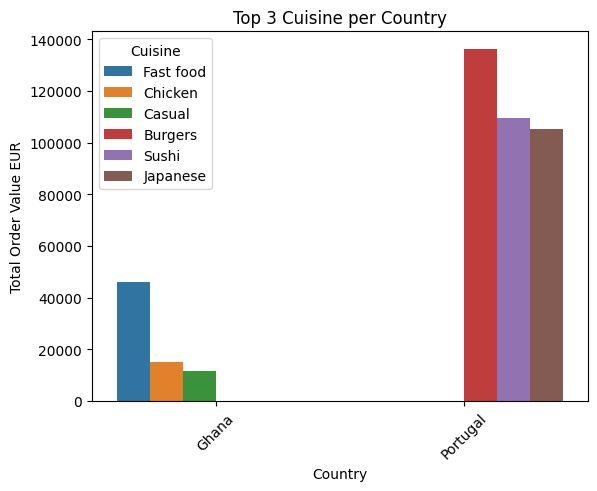

In [8]:
df_ops_desc = df_ops_clean.copy()

df_ops_desc = df_ops_desc.groupby(by=['Country','City','Cuisine']).agg(
    total_orders = ('Created Date','count'),
    total_products_ordered = ('Products in Order','sum'),
    total_order_value_eur = ('Order Value € (Gross)','sum')
).reset_index()

df_ops_desc['avg_products_per_order'] = df_ops_desc['total_products_ordered'] / df_ops_desc['total_orders']

df_ops_desc['avg_ticket'] = df_ops_desc['total_order_value_eur'] / df_ops_desc['total_orders']

df_ops_desc = df_ops_desc[[
    'Country','City','Cuisine','total_order_value_eur'
]].sort_values(by='total_order_value_eur',ascending=False)

df_ops_desc = pd.concat(
    [
        df_ops_desc[df_ops_desc['Country']=='Ghana'].head(3),
        df_ops_desc[df_ops_desc['Country']=='Portugal'].head(3)
    ],
    ignore_index=True\
)

# df_ops_desc[df_ops_desc['Country']=='Ghana'].head(3)
sns.barplot(
    data=df_ops_desc,
    y='total_order_value_eur',
    x='Country',
    hue='Cuisine'
)

plt.ylabel('Total Order Value EUR')
plt.title('Top 3 Cuisine per Country')
plt.xticks(rotation=45)
plt.show()

In [9]:
df_ops_desc = df_ops_clean.copy()

df_ops_desc = df_ops_desc.groupby(by=['Country','City']).agg(
    total_orders = ('Created Date','count'),
    total_products_ordered = ('Products in Order','sum'),
    total_order_value_eur = ('Order Value € (Gross)','sum')
).reset_index()

df_ops_desc['avg_products_per_order'] = df_ops_desc['total_products_ordered'] / df_ops_desc['total_orders']

df_ops_desc['avg_ticket'] = df_ops_desc['total_order_value_eur'] / df_ops_desc['total_orders']

In [10]:
df_ops_desc_order = df_ops_clean.copy()

df_ops_desc_order = df_ops_desc_order.groupby(by=['Country','City','Order State']).agg(Total = ('Created Date','count')).reset_index()

df_ops_desc_order = df_ops_desc_order.pivot_table(
    values='Total',
    index=['Country','City'],
    columns='Order State'
).reset_index()

df_ops_desc_order['fulfilment'] = df_ops_desc_order['delivered'] / (df_ops_desc_order['delivered'] + df_ops_desc_order['failed'] + df_ops_desc_order['rejected'])

df_ops_desc_order

Order State,Country,City,delivered,failed,rejected,fulfilment
0,Ghana,Accra,13351.00000,432.00000,349.00000,0.94474
1,Portugal,Lisbon,84585.00000,273.00000,628.00000,0.98946


In [32]:
df_ops_desc_order = df_ops_clean.copy()

df_ops_desc_order = df_ops_desc_order.groupby(by=['Order State','Cancel Reason']).agg(Total = ('Created Date','count')).reset_index()

df_ops_desc_order = df_ops_desc_order.pivot_table(
    values='Total',
    index=['Cancel Reason'],
    columns='Order State'
).reset_index()

df_ops_desc_order['ReasonsCount'] = df_ops_desc_order['failed'].fillna(0) + df_ops_desc_order['rejected'].fillna(0)

df_ops_desc_order

# df_ops_desc_order['ReasonsCount']
# df_ops_desc_order['fulfilment'] = df_ops_desc_order['delivered'] / (df_ops_desc_order['delivered'] + df_ops_desc_order['failed'] + df_ops_desc_order['rejected'])

# df_ops_desc_order

Order State,Cancel Reason,failed,rejected,ReasonsCount
0,Could not find a courier to deliver the order,352.00000,NaN,352.00000
1,The restaurant asked customer support to fail the order,301.00000,NaN,301.00000
2,The restaurant rejected the order,NaN,977.00000,977.00000
3,User cancellation,52.00000,NaN,52.00000


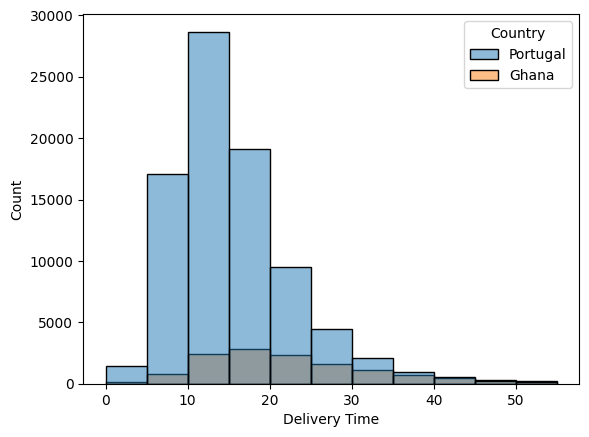

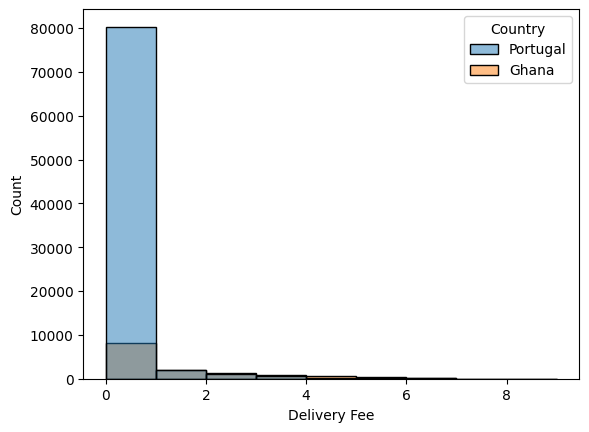

Delivery Fee Remarks,Country,Free Delivery,Paid Delivery,Free Delivery Perc
0,Ghana,7196.00000,6936.00000,0.50920
1,Portugal,76456.00000,9030.00000,0.89437


In [11]:
df_ops_desc_del = df_ops_clean.copy()

sns.histplot(
    data=df_ops_desc_del,
    hue='Country',
    x='Delivery Time',
    bins=(range(0,60,5))
)
plt.show()

sns.histplot(
    data=df_ops_desc_del,
    hue='Country',
    x='Delivery Fee',
    bins=(range(0,10,1))
)
plt.show()

df_ops_desc_del['Delivery Fee Remarks'] = np.where(
    df_ops_desc_del['Delivery Fee'] == 0,
    'Free Delivery',
    'Paid Delivery',
)

df_ops_desc_del = df_ops_desc_del.groupby(by=['Country','Delivery Fee Remarks'])['Created Date'].count().reset_index()

df_ops_desc_del = df_ops_desc_del.pivot_table(
    values='Created Date',
    columns='Delivery Fee Remarks',
    index='Country',
).reset_index()


df_ops_desc_del['Free Delivery Perc'] = df_ops_desc_del['Free Delivery'] / (df_ops_desc_del['Free Delivery'] + df_ops_desc_del['Paid Delivery'])

df_ops_desc_del

# Seasonality & Forecast

## Portugal

C:\Users\giovanni.cintra\AppData\Local\Temp\ipykernel_3080\3910712609.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.drop(columns=['Created Date','Country'],inplace=True)
C:\Users\giovanni.cintra\AppData\Local\Temp\ipykernel_3080\3910712609.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_plot.index[i], ts[i], df_plot['Weekday'][i], ha='right', va='bottom')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


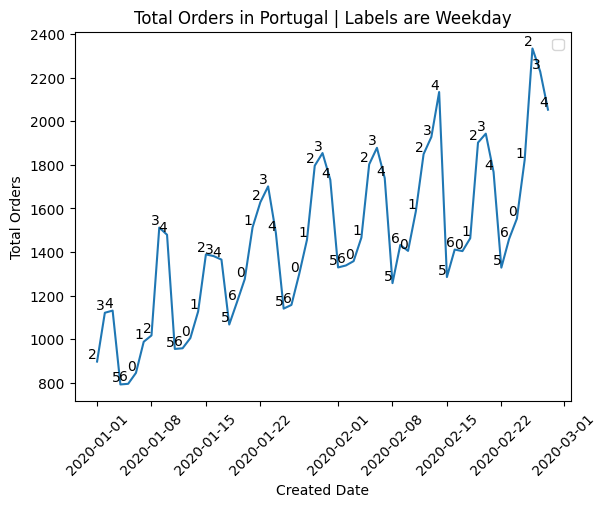

Dickey-Fuller Test indicates:
Test Statistic                -2.80680
p-value                        0.19446
#Lags Used                     7.00000
Number of Observations Used   51.00000
dtype: float64
None


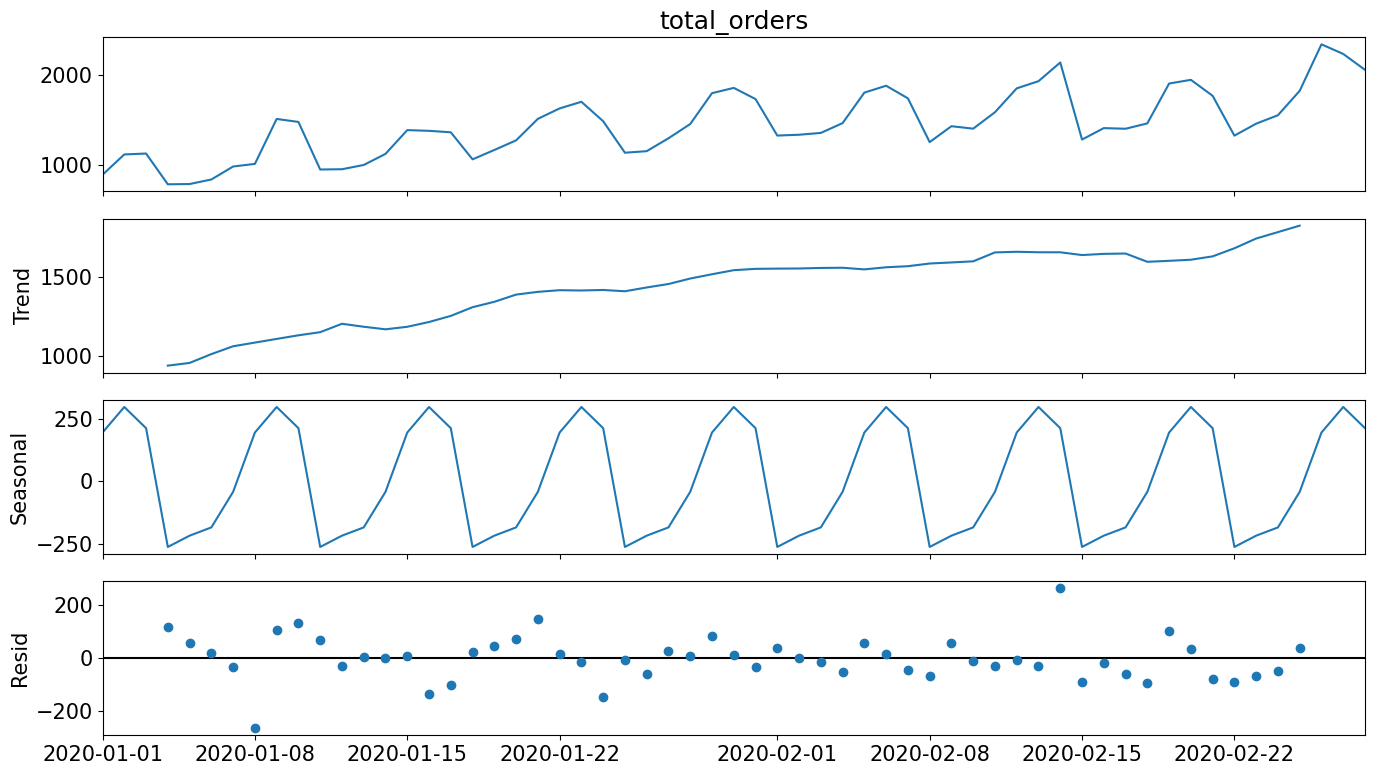

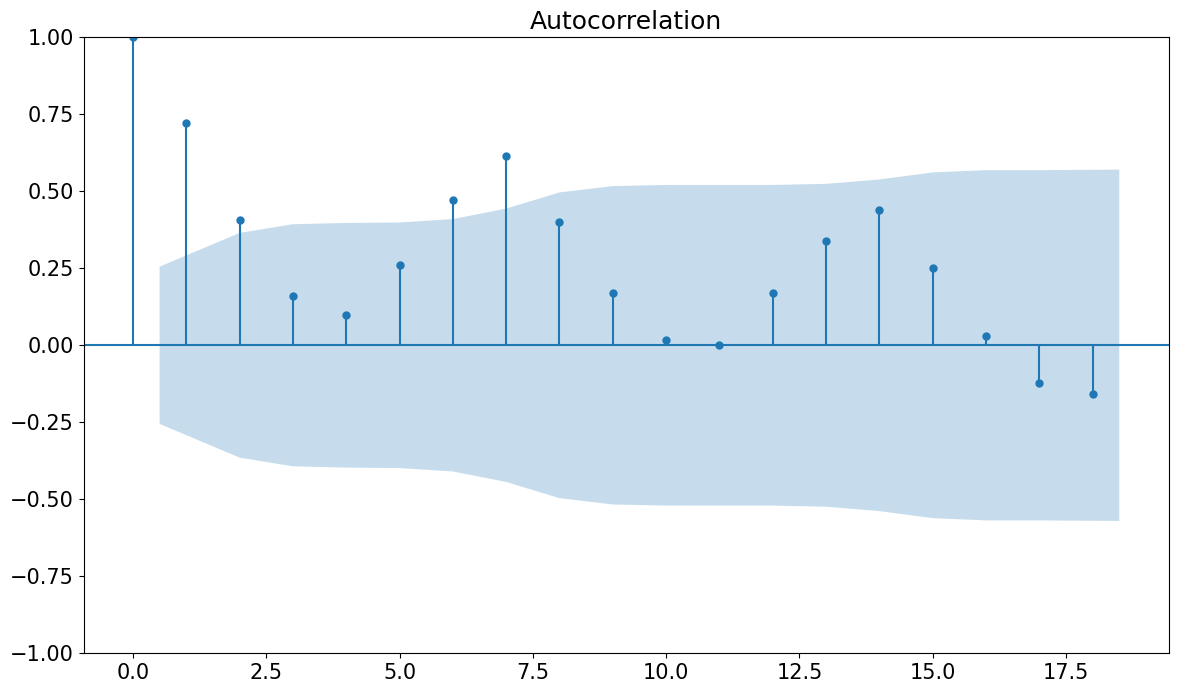

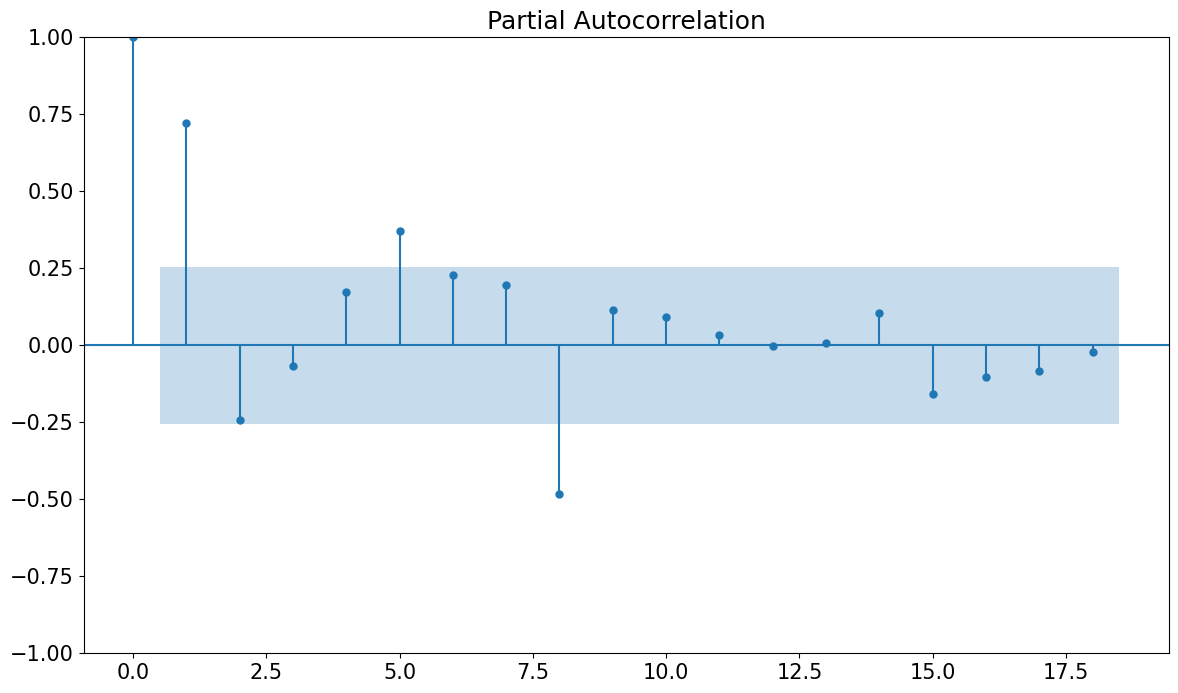

1 | 1 | 1 | 1 | 0 | 1
                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -367.369
Date:                           Wed, 10 Jan 2024   AIC                            744.738
Time:                                   13:55:09   BIC                            755.040
Sample:                               01-01-2020   HQIC                           748.751
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4925      0.140      3.518      0.000       0.218       0.767
ma.L1         -0.9022

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fou

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -367.264
Date:                                Wed, 10 Jan 2024   AIC                            746.527
Time:                                        13:55:10   BIC                            758.890
Sample:                                    01-01-2020   HQIC                           751.343
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4918      0.142      3.459      0.001       0.213       0.770
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -320.033
Date:                           Wed, 10 Jan 2024   AIC                            650.065
Time:                                   13:55:10   BIC                            659.724
Sample:                               01-01-2020   HQIC                           653.756
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4410      0.148      2.980      0.003       0.151       0.731
ma.L1         -0.8835      0.122     -7.219

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -319.835
Date:                                Wed, 10 Jan 2024   AIC                            651.670
Time:                                        13:55:10   BIC                            663.261
Sample:                                    01-01-2020   HQIC                           656.099
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4377      0.082      5.335      0.000       0.277       0.599
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -367.256
Date:                           Wed, 10 Jan 2024   AIC                            746.511
Time:                                   13:55:10   BIC                            758.874
Sample:                               01-01-2020   HQIC                           751.327
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4828      0.143      3.365      0.001       0.202       0.764
ma.L1         -0.8972      0.084    -10.677

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                -368.785
Date:                                Wed, 10 Jan 2024   AIC                            751.571
Time:                                        13:55:11   BIC                            765.994
Sample:                                    01-01-2020   HQIC                           757.189
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8100      0.138      5.873      0.000       0.540       1.080
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -320.577
Date:                                Wed, 10 Jan 2024   AIC                            655.155
Time:                                        13:55:11   BIC                            668.678
Sample:                                    01-01-2020   HQIC                           660.322
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5468      0.175      3.118      0.002       0.203       0.891
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -370.597
Date:                             Wed, 10 Jan 2024   AIC                            753.195
Time:                                     13:55:12   BIC                            765.558
Sample:                                 01-01-2020   HQIC                           758.010
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9975      0.389     -2.565      0.010      -1.760      -0.235
ma.L1          0.6054      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -320.032
Date:                             Wed, 10 Jan 2024   AIC                            652.064
Time:                                     13:55:12   BIC                            663.655
Sample:                                 01-01-2020   HQIC                           656.493
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4293      0.581      0.739      0.460      -0.709       1.568
ma.L1         -0.8697      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                -318.831
Date:                           Wed, 10 Jan 2024   AIC                            651.663
Time:                                   13:55:12   BIC                            665.185
Sample:                               01-01-2020   HQIC                           656.830
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4636      0.643      0.721      0.471      -0.796       1.723
ma.L1         -0.8957      0.689     -1.300

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using ze

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood                -368.704
Date:                             Wed, 10 Jan 2024   AIC                            751.408
Time:                                     13:55:13   BIC                            765.831
Sample:                                 01-01-2020   HQIC                           757.026
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4652      0.579      0.803      0.422      -0.670       1.600
ma.L1         -0.8737      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 7)   Log Likelihood                -368.121
Date:                           Wed, 10 Jan 2024   AIC                            752.241
Time:                                   13:55:13   BIC                            768.725
Sample:                               01-01-2020   HQIC                           758.662
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8921      0.234      3.819      0.000       0.434       1.350
ma.L1         -1.2364      0.309     -4.001

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 7)   Log Likelihood                -320.085
Date:                             Wed, 10 Jan 2024   AIC                            654.171
Time:                                     13:55:13   BIC                            667.694
Sample:                                 01-01-2020   HQIC                           659.338
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4137      0.571      0.724      0.469      -0.706       1.533
ma.L1         -0.8847      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 7)   Log Likelihood                -320.201
Date:                           Wed, 10 Jan 2024   AIC                            656.401
Time:                                   13:55:14   BIC                            671.856
Sample:                               01-01-2020   HQIC                           662.307
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4940      0.544      0.908      0.364      -0.573       1.561
ma.L1         -0.9796      0.585     -1.676

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fou

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -367.222
Date:                                Wed, 10 Jan 2024   AIC                            748.445
Time:                                        13:55:14   BIC                            762.868
Sample:                                    01-01-2020   HQIC                           754.063
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4992      0.144      3.463      0.001       0.217       0.782
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -318.832
Date:                                Wed, 10 Jan 2024   AIC                            651.664
Time:                                        13:55:15   BIC                            665.187
Sample:                                    01-01-2020   HQIC                           656.832
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4459      0.179      2.485      0.013       0.094       0.798
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -370.209
Date:                           Wed, 10 Jan 2024   AIC                            754.419
Time:                                   13:55:15   BIC                            768.842
Sample:                               01-01-2020   HQIC                           760.037
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7135      0.174      4.100      0.000       0.372       1.055
ar.L2          0.2029      0.189      1.075

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                -368.134
Date:                                Wed, 10 Jan 2024   AIC                            752.268
Time:                                        13:55:16   BIC                            768.751
Sample:                                    01-01-2020   HQIC                           758.688
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7047      0.184      3.830      0.000       0.344       1.065
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -320.009
Date:                           Wed, 10 Jan 2024   AIC                            654.018
Time:                                   13:55:16   BIC                            667.540
Sample:                               01-01-2020   HQIC                           659.185
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4432      0.147      3.025      0.002       0.156       0.730
ar.L2         -0.0105      0.247     -0.043

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -322.910
Date:                                Wed, 10 Jan 2024   AIC                            661.821
Time:                                        13:55:16   BIC                            677.276
Sample:                                    01-01-2020   HQIC                           667.727
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1305      0.789     -1.432      0.152      -2.677       0.417
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using ze

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 7)   Log Likelihood                -368.368
Date:                           Wed, 10 Jan 2024   AIC                            752.736
Time:                                   13:55:17   BIC                            769.220
Sample:                               01-01-2020   HQIC                           759.157
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4791      0.280     -1.708      0.088      -1.029       0.071
ar.L2          0.5173      0.164      3.162

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -319.854
Date:                             Wed, 10 Jan 2024   AIC                            653.707
Time:                                     13:55:17   BIC                            667.230
Sample:                                 01-01-2020   HQIC                           658.875
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5423      0.234     -2.318      0.020      -1.001      -0.084
ar.L2          0.4573      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 7)   Log Likelihood                -318.635
Date:                           Wed, 10 Jan 2024   AIC                            653.269
Time:                                   13:55:17   BIC                            668.724
Sample:                               01-01-2020   HQIC                           659.175
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5226      0.226     -2.313      0.021      -0.965      -0.080
ar.L2          0.4748      0.163      2.906

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 7)   Log Likelihood                -367.183
Date:                             Wed, 10 Jan 2024   AIC                            750.365
Time:                                     13:55:18   BIC                            766.849
Sample:                                 01-01-2020   HQIC                           756.786
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2203      1.639     -0.134      0.893      -3.434       2.993
ar.L2          0.3158      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood                -368.463
Date:                           Wed, 10 Jan 2024   AIC                            754.926
Time:                                   13:55:18   BIC                            773.469
Sample:                               01-01-2020   HQIC                           762.149
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1941      0.149     -1.300      0.193      -0.487       0.098
ar.L2          0.8052      0.153      5.263

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood                -320.431
Date:                             Wed, 10 Jan 2024   AIC                            656.862
Time:                                     13:55:19   BIC                            672.316
Sample:                                 01-01-2020   HQIC                           662.767
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2587      1.917     -0.135      0.893      -4.017       3.499
ar.L2          0.2913      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
df_ops_season = df_ops_clean.copy()

df_ops_season = df_ops_season.groupby(by=['Created Date','Country','Weekday']).agg(total_orders = ('Created Date','count')).reset_index()

country = 'Portugal'


df_plot = df_ops_season[df_ops_season['Country']==country]
df_plot.index = pd.to_datetime(df_plot['Created Date'], format='%Y-%m-%d')
df_plot.drop(columns=['Created Date','Country'],inplace=True)
ts = df_plot['total_orders']


plt.xticks(rotation=45)
plt.plot(
    ts
)
for i, txt in enumerate(ts):
    plt.text(df_plot.index[i], ts[i], df_plot['Weekday'][i], ha='right', va='bottom')

plt.title(f'Total Orders in {country} | Labels are Weekday')
plt.ylabel('Total Orders')
plt.xlabel('Created Date')
plt.legend()
plt.show()


plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(ts,model='additive')
fig = result.plot()

print(ad_fuller(ts))

plot_acf(ts)
plt.show()
plot_pacf(ts)
plt.show()

d_values = [1]
D_values = [0, 1]

q_values = [1, 2]
Q_values = [1, 2]

p_values = [1, 2]
P_values = [1, 2]

s_values = [7]

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        print(f'{p} | {d} | {q} | {P} | {D} | {Q}')
                        s = 7

                        SARIMAXmodel = SARIMAX(
                            ts, 
                            order = (p, d, q), 
                            seasonal_order=(P, D, Q, s),
                            dynamic=True)
                        SARIMAXmodel = SARIMAXmodel.fit()
                        print(SARIMAXmodel.summary())


# train = ts

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


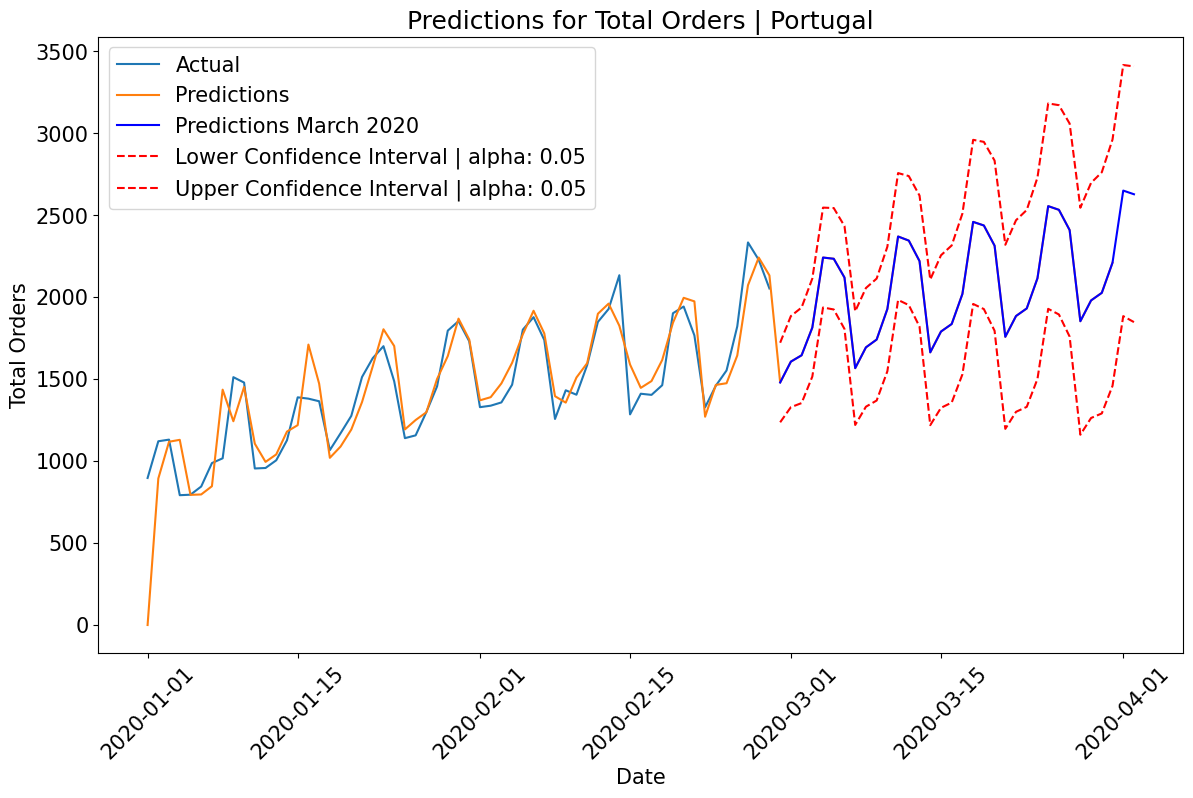

With 95% of confidence, the Total Orders of March 2020 for portugal will vary between: 48289.727753485524 and 78325.83491019983
The expected value for portugal would be: 63307.78133184268


In [13]:
# BEST MODEL: SARIMAX(1, 1, 1)x(1, 1, 1, 7) LOWER AIC

SARIMAXmodel = SARIMAX(
    ts, 
    order = (1, 1, 1), 
    seasonal_order=(1, 1, 1, 7),
    dynamic=True)
SARIMAXmodel = SARIMAXmodel.fit()
predictions = SARIMAXmodel.predict(start = '2020-01-01', end = '2020-03-31')


plt.plot(ts, label = 'Actual')
plt.plot(predictions, label = 'Predictions')
plt.ylabel('Total Orders')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title(f"Predictions for Total Orders | {country}")




y_pred_df = pd.DataFrame(
    index=pd.date_range(start='2020-03-01', end ='2020-03-31'),
    columns=['Predictions'],
    data=np.nan)

y_pred = SARIMAXmodel.get_forecast(len(pd.date_range(start='2020-02-27', end ='2020-03-31')))

y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = '2020-01-01', end = '2020-04-30')
# y_pred_df["Predictions"] = SARIMAXmodel.predict(start = '2020-01-01'y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=True)

y_pred_out = y_pred_df["Predictions"]
y_pred_lower = y_pred_df["lower total_orders"]
y_pred_upper = y_pred_df["upper total_orders"]

plt.plot(y_pred_out, color='Blue', label = 'Predictions March 2020')
plt.plot(y_pred_lower, color='Red', label = 'Lower Confidence Interval | alpha: 0.05', linestyle='dashed')
plt.plot(y_pred_upper, color='Red', label = 'Upper Confidence Interval | alpha: 0.05', linestyle='dashed')
plt.legend()
plt.show()

df_final_portugal = y_pred_df[(y_pred_df.index >= '2020-03-01') & (y_pred_df.index <= '2020-03-31')]

print('With 95% of confidence, the Total Orders of March 2020 for portugal will vary between: ' + str(np.sum(df_final_portugal['lower total_orders'])) + ' and ' + str(np.sum(df_final_portugal['upper total_orders'])))
print('The expected value for portugal would be: ' + str(np.sum(df_final_portugal['Predictions'])))    

## Ghana

C:\Users\giovanni.cintra\AppData\Local\Temp\ipykernel_3080\1933788019.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.drop(columns=['Created Date','Country'],inplace=True)
C:\Users\giovanni.cintra\AppData\Local\Temp\ipykernel_3080\1933788019.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_plot.index[i], ts[i], df_plot['Weekday'][i], ha='right', va='bottom')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


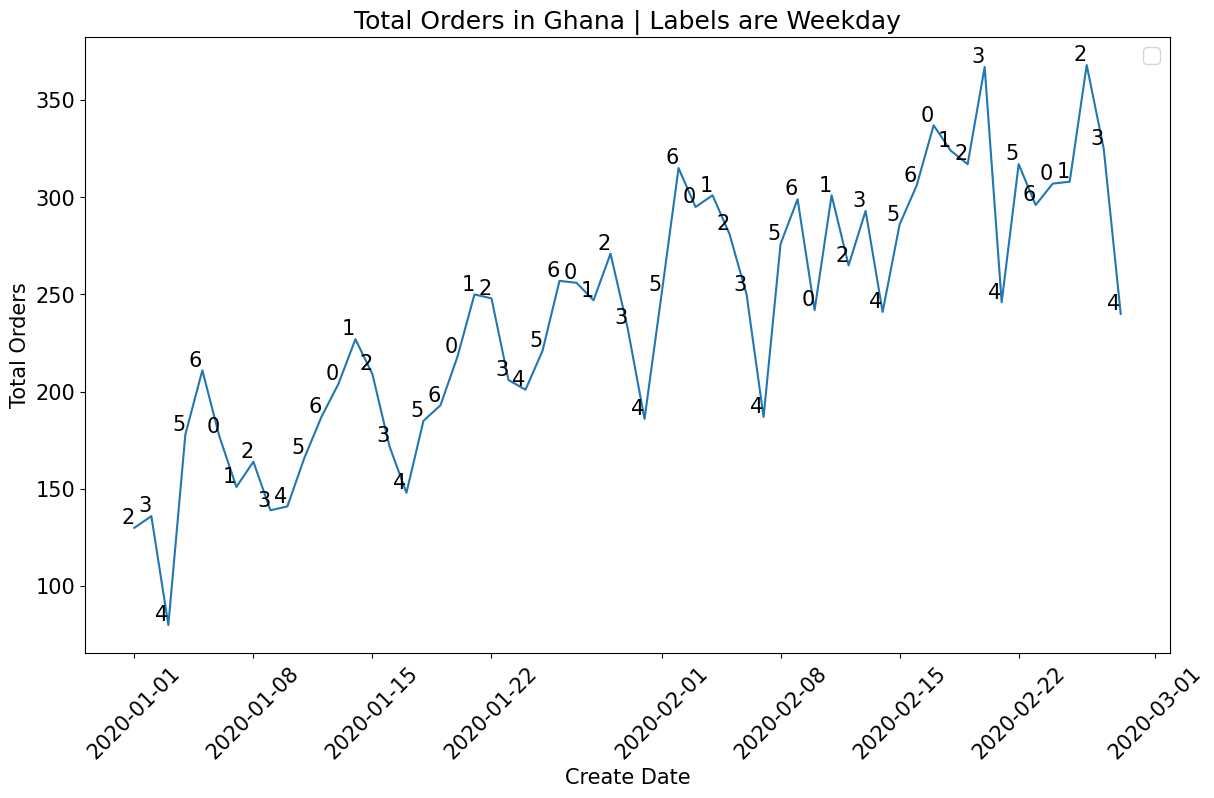

Dickey-Fuller Test indicates:
Test Statistic                -2.15247
p-value                        0.51662
#Lags Used                     9.00000
Number of Observations Used   49.00000
dtype: float64
None


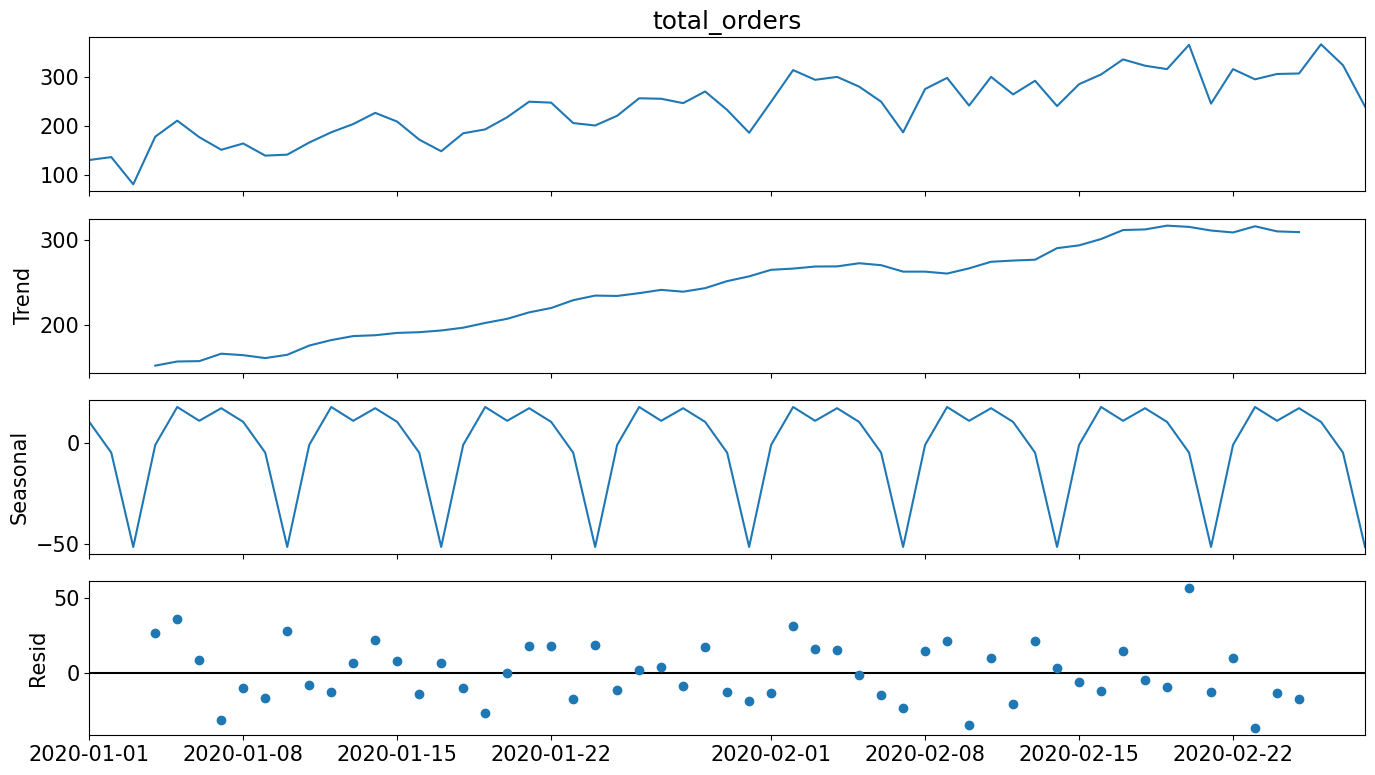

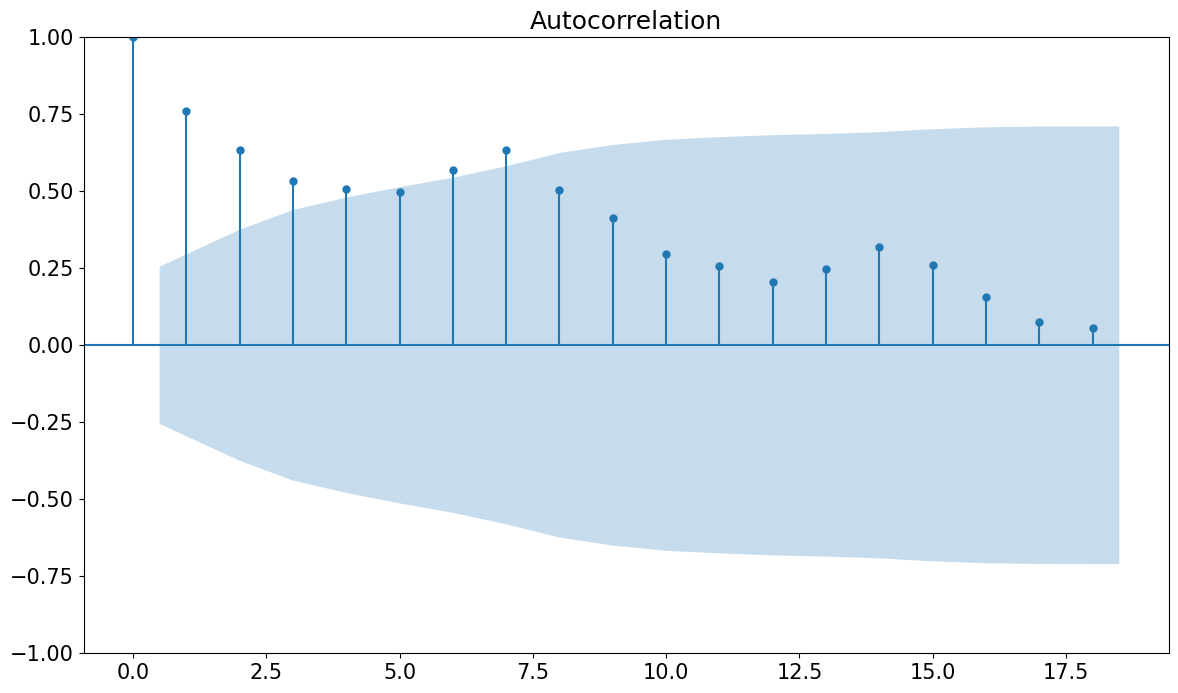

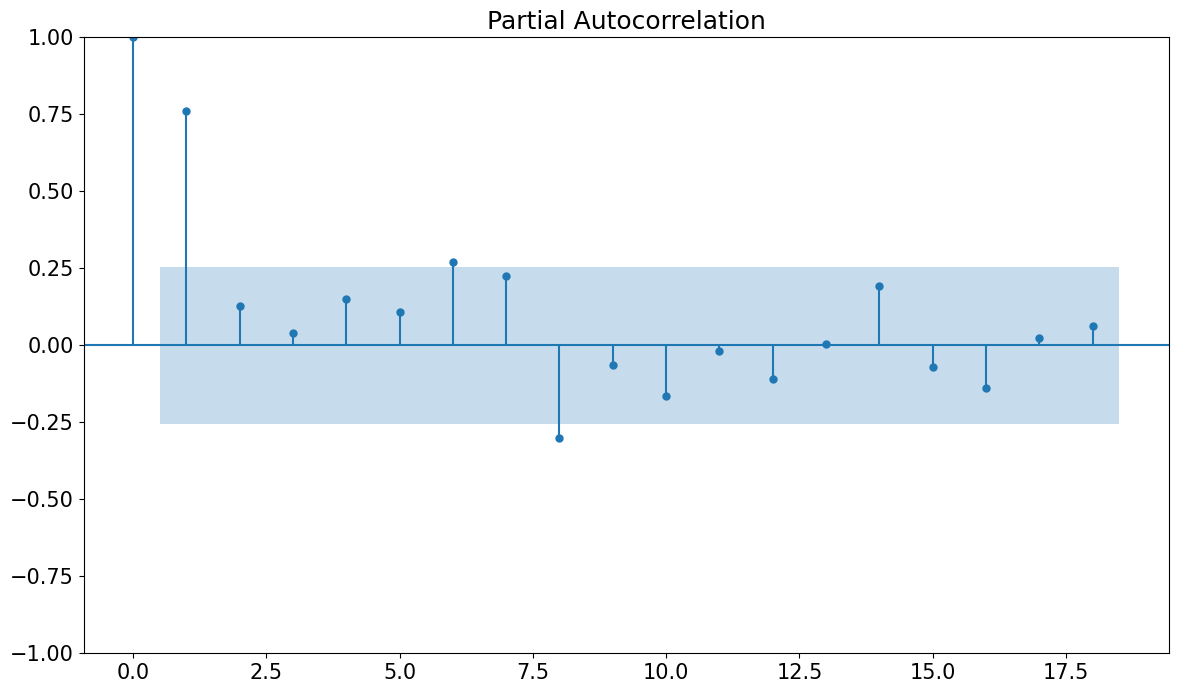

1 | 1 | 1 | 1 | 0 | 1
                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -277.714
Date:                           Wed, 10 Jan 2024   AIC                            565.429
Time:                                   13:55:21   BIC                            575.731
Sample:                               01-01-2020   HQIC                           569.442
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1295      0.208      0.622      0.534      -0.279       0.538
ma.L1         -0.8419

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequ

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -277.164
Date:                                Wed, 10 Jan 2024   AIC                            566.328
Time:                                        13:55:21   BIC                            578.690
Sample:                                    01-01-2020   HQIC                           571.143
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1780      0.202      0.880      0.379      -0.218       0.574
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.020
Date:                                      Wed, 10 Jan 2024   AIC                            570.041
Time:                                              13:55:22   BIC                            586.524
Sample:                                          01-01-2020   HQIC                           576.462
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1483      0.209  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2, 3], 7)   Log Likelihood                -243.126
Date:                                   Wed, 10 Jan 2024   AIC                            500.253
Time:                                           13:55:23   BIC                            513.776
Sample:                                       01-01-2020   HQIC                           505.420
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2073      0.210      0.987      0.324    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequ

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                -277.078
Date:                                Wed, 10 Jan 2024   AIC                            568.157
Time:                                        13:55:24   BIC                            582.580
Sample:                                    01-01-2020   HQIC                           573.775
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1756      0.215      0.817      0.414      -0.245       0.597
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -277.013
Date:                                   Wed, 10 Jan 2024   AIC                            570.026
Time:                                           13:55:24   BIC                            586.509
Sample:                                       01-01-2020   HQIC                           576.446
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1890      0.217      0.872      0.383    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -243.079
Date:                           Wed, 10 Jan 2024   AIC                            498.157
Time:                                   13:55:25   BIC                            509.748
Sample:                               01-01-2020   HQIC                           502.587
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1577      0.215      0.732      0.464      -0.264       0.580
ma.L1         -0.9221      0.155     -5.934

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -243.107
Date:                                Wed, 10 Jan 2024   AIC                            500.215
Time:                                        13:55:25   BIC                            513.738
Sample:                                    01-01-2020   HQIC                           505.382
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1814      0.225      0.808      0.419      -0.259       0.622
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -243.078
Date:                                   Wed, 10 Jan 2024   AIC                            502.155
Time:                                           13:55:26   BIC                            517.610
Sample:                                       01-01-2020   HQIC                           508.061
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1753      0.207      0.845      0.398    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood                -243.114
Date:                                      Wed, 10 Jan 2024   AIC                            504.228
Time:                                              13:55:26   BIC                            521.614
Sample:                                          01-01-2020   HQIC                           510.872
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2020      0.213  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 7)   Log Likelihood                -277.163
Date:                           Wed, 10 Jan 2024   AIC                            568.327
Time:                                   13:55:27   BIC                            582.750
Sample:                               01-01-2020   HQIC                           573.945
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2199      1.176      0.187      0.852      -2.085       2.525
ma.L1         -0.8909      1.159     -0.769

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 0, [1, 2, 3], 7)   Log Likelihood                -277.058
Date:                                   Wed, 10 Jan 2024   AIC                            570.116
Time:                                           13:55:27   BIC                            586.600
Sample:                                       01-01-2020   HQIC                           576.537
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2197      1.374      0.160      0.873    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.026
Date:                                      Wed, 10 Jan 2024   AIC                            572.052
Time:                                              13:55:27   BIC                            590.596
Sample:                                          01-01-2020   HQIC                           579.275
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2682      1.458  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                -243.137
Date:                           Wed, 10 Jan 2024   AIC                            500.274
Time:                                   13:55:28   BIC                            513.797
Sample:                               01-01-2020   HQIC                           505.442
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9096      0.159     -5.719      0.000      -1.221      -0.598
ma.L1          0.1019      2.352      0.043

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 1, [1, 2, 3, 4], 7)   Log Likelihood                -242.910
Date:                                      Wed, 10 Jan 2024   AIC                            503.819
Time:                                              13:55:29   BIC                            521.206
Sample:                                          01-01-2020   HQIC                           510.463
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9291      0.153  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood                -277.319
Date:                             Wed, 10 Jan 2024   AIC                            568.637
Time:                                     13:55:29   BIC                            583.060
Sample:                                 01-01-2020   HQIC                           574.255
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1860      1.231      0.151      0.880      -2.226       2.598
ma.L1         -0.8652      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 7)   Log Likelihood                -277.123
Date:                           Wed, 10 Jan 2024   AIC                            570.245
Time:                                   13:55:30   BIC                            586.729
Sample:                               01-01-2020   HQIC                           576.666
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2103      1.185      0.178      0.859      -2.112       2.533
ma.L1         -0.8773      1.161     -0.755

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -277.028
Date:                                   Wed, 10 Jan 2024   AIC                            572.056
Time:                                           13:55:30   BIC                            590.600
Sample:                                       01-01-2020   HQIC                           579.279
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2311      1.096      0.211      0.833    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.018
Date:                                      Wed, 10 Jan 2024   AIC                            574.037
Time:                                              13:55:31   BIC                            594.641
Sample:                                          01-01-2020   HQIC                           582.063
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2246      1.247  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 7)   Log Likelihood                -243.073
Date:                             Wed, 10 Jan 2024   AIC                            500.146
Time:                                     13:55:31   BIC                            513.669
Sample:                                 01-01-2020   HQIC                           505.313
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9158      0.165     -5.543      0.000      -1.240      -0.592
ma.L1          0.1109     1

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 7)   Log Likelihood                -242.945
Date:                           Wed, 10 Jan 2024   AIC                            501.891
Time:                                   13:55:31   BIC                            517.345
Sample:                               01-01-2020   HQIC                           507.796
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9322      0.162     -5.751      0.000      -1.250      -0.615
ma.L1          0.1207      1.370      0.088

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -243.040
Date:                                   Wed, 10 Jan 2024   AIC                            504.080
Time:                                           13:55:32   BIC                            521.467
Sample:                                       01-01-2020   HQIC                           510.724
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8807      0.150     -5.869      0.000    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood                -243.003
Date:                                      Wed, 10 Jan 2024   AIC                            506.005
Time:                                              13:55:33   BIC                            525.323
Sample:                                          01-01-2020   HQIC                           513.387
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8859      0.152  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(1, 0, [1, 2], 7)   Log Likelihood                -277.152
Date:                                Wed, 10 Jan 2024   AIC                            570.304
Time:                                        13:55:33   BIC                            586.788
Sample:                                    01-01-2020   HQIC                           576.725
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0226      3.267      0.007      0.994      -6.381       6.427
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 7)   Log Likelihood                -277.039
Date:                           Wed, 10 Jan 2024   AIC                            572.078
Time:                                   13:55:34   BIC                            590.622
Sample:                               01-01-2020   HQIC                           579.301
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5864      2.141     -0.274      0.784      -4.783       3.611
ma.L1         -0.0811      2.048     -0.040

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.022
Date:                                      Wed, 10 Jan 2024   AIC                            574.045
Time:                                              13:55:35   BIC                            594.649
Sample:                                          01-01-2020   HQIC                           582.070
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6206      2.043  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(1, 1, [1, 2], 7)   Log Likelihood                -243.043
Date:                                Wed, 10 Jan 2024   AIC                            502.087
Time:                                        13:55:36   BIC                            517.541
Sample:                                    01-01-2020   HQIC                           507.992
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9416      0.189     -4.982      0.000      -1.312      -0.571
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(1, 1, [1, 2, 3, 4], 7)   Log Likelihood                -243.027
Date:                                      Wed, 10 Jan 2024   AIC                            506.054
Time:                                              13:55:37   BIC                            525.373
Sample:                                          01-01-2020   HQIC                           513.436
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9391      0.187  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 0, [1], 7)   Log Likelihood                -277.279
Date:                             Wed, 10 Jan 2024   AIC                            570.558
Time:                                     13:55:37   BIC                            587.042
Sample:                                 01-01-2020   HQIC                           576.979
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5978      2.204     -0.271      0.786      -4.917       3.721
ma.L1         -0.0813      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood                -276.978
Date:                                Wed, 10 Jan 2024   AIC                            571.956
Time:                                        13:55:38   BIC                            590.500
Sample:                                    01-01-2020   HQIC                           579.179
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6143      1.645     -0.373      0.709      -3.839       2.611
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 0, 3, 7)   Log Likelihood                -276.942
Date:                           Wed, 10 Jan 2024   AIC                            573.885
Time:                                   13:55:39   BIC                            594.489
Sample:                               01-01-2020   HQIC                           581.910
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6050      1.804     -0.335      0.737      -4.141       2.931
ma.L1         -0.0496      1.700     -0.029

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.028
Date:                                      Wed, 10 Jan 2024   AIC                            576.057
Time:                                              13:55:40   BIC                            598.722
Sample:                                          01-01-2020   HQIC                           584.885
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5725      2.171  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 1, [1, 2], 7)   Log Likelihood                -243.042
Date:                                Wed, 10 Jan 2024   AIC                            504.084
Time:                                        13:55:40   BIC                            521.470
Sample:                                    01-01-2020   HQIC                           510.728
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9383      0.191     -4.912      0.000      -1.313      -0.564
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 3)x(2, 1, 3, 7)   Log Likelihood                -243.039
Date:                           Wed, 10 Jan 2024   AIC                            506.078
Time:                                   13:55:41   BIC                            525.396
Sample:                               01-01-2020   HQIC                           513.460
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9354      0.214     -4.368      0.000      -1.355      -0.516
ma.L1          0.1273    342.057      0.000

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 0, [1], 7)   Log Likelihood                -277.472
Date:                             Wed, 10 Jan 2024   AIC                            570.943
Time:                                     13:55:42   BIC                            587.427
Sample:                                 01-01-2020   HQIC                           577.364
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5892      0.960     -0.613      0.540      -2.472       1.293
ma.L1         -0.1091      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 0, [1, 2, 3], 7)   Log Likelihood                -277.024
Date:                                   Wed, 10 Jan 2024   AIC                            574.048
Time:                                           13:55:43   BIC                            594.653
Sample:                                       01-01-2020   HQIC                           582.074
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5958      2.462     -0.242      0.809    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 0, 4, 7)   Log Likelihood                -277.025
Date:                           Wed, 10 Jan 2024   AIC                            576.050
Time:                                   13:55:44   BIC                            598.715
Sample:                               01-01-2020   HQIC                           584.879
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6084      2.213     -0.275      0.783      -4.946       3.730
ma.L1         -0.0573      2.159     -0.027

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 1, [1], 7)   Log Likelihood                -242.760
Date:                             Wed, 10 Jan 2024   AIC                            501.520
Time:                                     13:55:44   BIC                            516.975
Sample:                                 01-01-2020   HQIC                           507.426
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9010      0.181     -4.968      0.000      -1.256      -0.546
ma.L1          0.1531      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood                -242.728
Date:                                Wed, 10 Jan 2024   AIC                            503.455
Time:                                        13:55:45   BIC                            520.841
Sample:                                    01-01-2020   HQIC                           510.099
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9032      0.194     -4.662      0.000      -1.283      -0.523
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 1, [1, 2, 3], 7)   Log Likelihood                -242.712
Date:                                   Wed, 10 Jan 2024   AIC                            505.425
Time:                                           13:55:45   BIC                            524.743
Sample:                                       01-01-2020   HQIC                           512.807
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9004      0.225     -4.008      0.000    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 7)   Log Likelihood                -242.708
Date:                           Wed, 10 Jan 2024   AIC                            507.417
Time:                                   13:55:46   BIC                            528.667
Sample:                               01-01-2020   HQIC                           515.537
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9021      0.206     -4.381      0.000      -1.306      -0.499
ma.L1          0.1137     13.596      0.008

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 0, [1, 2], 7)   Log Likelihood                -276.914
Date:                                Wed, 10 Jan 2024   AIC                            573.829
Time:                                        13:55:47   BIC                            594.433
Sample:                                    01-01-2020   HQIC                           581.854
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5974      1.417     -0.422      0.673      -3.374       2.179
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -276.929
Date:                                   Wed, 10 Jan 2024   AIC                            575.858
Time:                                           13:55:48   BIC                            598.523
Sample:                                       01-01-2020   HQIC                           584.687
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6151      1.660     -0.371      0.711    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 0, 4, 7)   Log Likelihood                -277.041
Date:                           Wed, 10 Jan 2024   AIC                            578.081
Time:                                   13:55:49   BIC                            602.807
Sample:                               01-01-2020   HQIC                           587.712
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5920      2.880     -0.206      0.837      -6.236       5.052
ma.L1         -0.0652      2.801     -0.023

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 1, [1], 7)   Log Likelihood                -242.689
Date:                             Wed, 10 Jan 2024   AIC                            503.378
Time:                                     13:55:49   BIC                            520.764
Sample:                                 01-01-2020   HQIC                           510.022
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9050      0.198     -4.562      0.000      -1.294      -0.516
ma.L1          0.1182    30

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 1, [1, 2], 7)   Log Likelihood                -242.671
Date:                                Wed, 10 Jan 2024   AIC                            505.342
Time:                                        13:55:50   BIC                            524.660
Sample:                                    01-01-2020   HQIC                           512.724
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8989      0.200     -4.494      0.000      -1.291      -0.507
ma.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -242.714
Date:                                   Wed, 10 Jan 2024   AIC                            507.429
Time:                                           13:55:50   BIC                            528.679
Sample:                                       01-01-2020   HQIC                           515.549
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9022      0.220     -4.096      0.000    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(1, 1, 4)x(2, 1, 4, 7)   Log Likelihood                -242.688
Date:                           Wed, 10 Jan 2024   AIC                            509.375
Time:                                   13:55:51   BIC                            532.557
Sample:                               01-01-2020   HQIC                           518.234
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9062      0.225     -4.029      0.000      -1.347      -0.465
ma.L1          0.1077     52.454      0.002

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -277.162
Date:                                Wed, 10 Jan 2024   AIC                            568.323
Time:                                        13:55:52   BIC                            582.747
Sample:                                    01-01-2020   HQIC                           573.942
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1778      0.213      0.836      0.403      -0.239       0.595
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.000
Date:                                      Wed, 10 Jan 2024   AIC                            572.001
Time:                                              13:55:53   BIC                            590.545
Sample:                                          01-01-2020   HQIC                           579.224
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1512      0.225  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2, 3], 7)   Log Likelihood                -243.075
Date:                                   Wed, 10 Jan 2024   AIC                            502.150
Time:                                           13:55:54   BIC                            517.605
Sample:                                       01-01-2020   HQIC                           508.056
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1987      0.229      0.867      0.386    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequ

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                -277.082
Date:                                Wed, 10 Jan 2024   AIC                            570.164
Time:                                        13:55:55   BIC                            586.648
Sample:                                    01-01-2020   HQIC                           576.585
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1806      0.227      0.796      0.426      -0.264       0.625
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -277.019
Date:                                   Wed, 10 Jan 2024   AIC                            572.038
Time:                                           13:55:55   BIC                            590.582
Sample:                                       01-01-2020   HQIC                           579.261
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1937      0.230      0.844      0.399    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.022
Date:                                      Wed, 10 Jan 2024   AIC                            574.043
Time:                                              13:55:56   BIC                            594.648
Sample:                                          01-01-2020   HQIC                           582.069
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.245  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 7)   Log Likelihood                -243.035
Date:                                Wed, 10 Jan 2024   AIC                            502.070
Time:                                        13:55:57   BIC                            517.525
Sample:                                    01-01-2020   HQIC                           507.976
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1721      0.218      0.789      0.430      -0.255       0.599
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -242.972
Date:                                   Wed, 10 Jan 2024   AIC                            503.944
Time:                                           13:55:57   BIC                            521.330
Sample:                                       01-01-2020   HQIC                           510.588
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1634      0.221      0.740      0.460    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood                -243.059
Date:                                      Wed, 10 Jan 2024   AIC                            506.119
Time:                                              13:55:58   BIC                            525.437
Sample:                                          01-01-2020   HQIC                           513.501
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1684      0.225  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fou

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 7)   Log Likelihood                -277.149
Date:                           Wed, 10 Jan 2024   AIC                            570.297
Time:                                   13:55:59   BIC                            586.781
Sample:                               01-01-2020   HQIC                           576.718
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4121      4.362     -0.094      0.925      -8.961       8.136
ar.L2          0.1255      0.647      0.194

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 0, [1, 2, 3], 7)   Log Likelihood                -277.000
Date:                                   Wed, 10 Jan 2024   AIC                            572.001
Time:                                           13:55:59   BIC                            590.545
Sample:                                       01-01-2020   HQIC                           579.224
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4189      2.557     -0.164      0.870    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.050
Date:                                      Wed, 10 Jan 2024   AIC                            574.101
Time:                                              13:56:00   BIC                            594.705
Sample:                                          01-01-2020   HQIC                           582.127
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3833      3.822  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Usin

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 7)   Log Likelihood                -243.194
Date:                           Wed, 10 Jan 2024   AIC                            502.387
Time:                                   13:56:01   BIC                            517.842
Sample:                               01-01-2020   HQIC                           508.293
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7788      0.265     -2.941      0.003      -1.298      -0.260
ar.L2          0.1551      0.241      0.645

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, [1, 2, 3], 7)   Log Likelihood                -242.936
Date:                                   Wed, 10 Jan 2024   AIC                            503.871
Time:                                           13:56:01   BIC                            521.258
Sample:                                       01-01-2020   HQIC                           510.515
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7728      0.272     -2.840      0.005    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, [1, 2, 3, 4], 7)   Log Likelihood                -243.042
Date:                                      Wed, 10 Jan 2024   AIC                            506.083
Time:                                              13:56:02   BIC                            525.402
Sample:                                          01-01-2020   HQIC                           513.466
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1416      3.433  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fou

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood                -277.030
Date:                           Wed, 10 Jan 2024   AIC                            572.060
Time:                                   13:56:03   BIC                            590.604
Sample:                               01-01-2020   HQIC                           579.283
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4114      2.716     -0.151      0.880      -5.735       4.912
ar.L2          0.1429      0.377      0.379

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fou

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -276.998
Date:                                   Wed, 10 Jan 2024   AIC                            573.995
Time:                                           13:56:03   BIC                            594.600
Sample:                                       01-01-2020   HQIC                           582.021
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3664      3.751     -0.098      0.922    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 0, [1, 2, 3, 4], 7)   Log Likelihood                -277.004
Date:                                      Wed, 10 Jan 2024   AIC                            576.007
Time:                                              13:56:04   BIC                            598.672
Sample:                                          01-01-2020   HQIC                           584.836
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1922      7.211  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood                -242.935
Date:                             Wed, 10 Jan 2024   AIC                            501.871
Time:                                     13:56:04   BIC                            517.325
Sample:                                 01-01-2020   HQIC                           507.776
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7777      0.185     -4.201      0.000      -1.141      -0.415
ar.L2          0.1571      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood                -242.883
Date:                           Wed, 10 Jan 2024   AIC                            503.766
Time:                                   13:56:05   BIC                            521.153
Sample:                               01-01-2020   HQIC                           510.410
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2817      2.247     -0.125      0.900      -4.686       4.122
ar.L2          0.1184      0.222      0.534

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -242.773
Date:                                   Wed, 10 Jan 2024   AIC                            505.545
Time:                                           13:56:05   BIC                            524.863
Sample:                                       01-01-2020   HQIC                           512.927
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7853      0.238     -3.301      0.001    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood                -242.954
Date:                                      Wed, 10 Jan 2024   AIC                            507.908
Time:                                              13:56:06   BIC                            529.158
Sample:                                          01-01-2020   HQIC                           516.029
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1837      2.428  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 7)   Log Likelihood                -277.560
Date:                             Wed, 10 Jan 2024   AIC                            571.119
Time:                                     13:56:07   BIC                            587.603
Sample:                                 01-01-2020   HQIC                           577.540
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1811      0.660      1.790      0.073      -0.112       2.474
ar.L2         -0.6704      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 0, [1, 2], 7)   Log Likelihood                -275.440
Date:                                Wed, 10 Jan 2024   AIC                            568.880
Time:                                        13:56:07   BIC                            587.424
Sample:                                    01-01-2020   HQIC                           576.103
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4552      0.462      3.150      0.002       0.550       2.361
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 0, 3, 7)   Log Likelihood                -275.313
Date:                           Wed, 10 Jan 2024   AIC                            570.626
Time:                                   13:56:08   BIC                            591.231
Sample:                               01-01-2020   HQIC                           578.652
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4504      0.460      3.155      0.002       0.549       2.351
ar.L2         -0.5134      0.444     -1.156

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood                -275.297
Date:                                      Wed, 10 Jan 2024   AIC                            572.593
Time:                                              13:56:09   BIC                            595.258
Sample:                                          01-01-2020   HQIC                           581.422
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4812      0.539  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood                -242.925
Date:                             Wed, 10 Jan 2024   AIC                            501.851
Time:                                     13:56:10   BIC                            517.305
Sample:                                 01-01-2020   HQIC                           507.756
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5357      0.963     -0.556      0.578      -2.423       1.352
ar.L2          0.3704      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 7)   Log Likelihood                -242.824
Date:                                Wed, 10 Jan 2024   AIC                            503.648
Time:                                        13:56:10   BIC                            521.035
Sample:                                    01-01-2020   HQIC                           510.292
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5550      1.453     -0.382      0.702      -3.403       2.293
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 1, 3, 7)   Log Likelihood                -242.852
Date:                           Wed, 10 Jan 2024   AIC                            505.705
Time:                                   13:56:11   BIC                            525.023
Sample:                               01-01-2020   HQIC                           513.087
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5193      1.167     -0.445      0.656      -2.807       1.769
ar.L2          0.3903      1.072      0.364

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2, 3, 4], 7)   Log Likelihood                -242.804
Date:                                      Wed, 10 Jan 2024   AIC                            507.607
Time:                                              13:56:12   BIC                            528.858
Sample:                                          01-01-2020   HQIC                           515.728
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4476      1.288  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 0, [1], 7)   Log Likelihood                -275.442
Date:                             Wed, 10 Jan 2024   AIC                            568.885
Time:                                     13:56:12   BIC                            587.429
Sample:                                 01-01-2020   HQIC                           576.108
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2808      0.034     37.298      0.000       1.213       1.348
ar.L2         -0.9983      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood                -276.408
Date:                                Wed, 10 Jan 2024   AIC                            572.817
Time:                                        13:56:13   BIC                            593.421
Sample:                                    01-01-2020   HQIC                           580.842
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9096      0.313      2.904      0.004       0.296       1.523
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 0, 3, 7)   Log Likelihood                -275.412
Date:                           Wed, 10 Jan 2024   AIC                            572.823
Time:                                   13:56:14   BIC                            595.488
Sample:                               01-01-2020   HQIC                           581.652
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4423      0.473      3.051      0.002       0.516       2.369
ar.L2         -0.5059      0.473     -1.070

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2, 3, 4], 7)   Log Likelihood                -275.282
Date:                                      Wed, 10 Jan 2024   AIC                            574.564
Time:                                              13:56:15   BIC                            599.290
Sample:                                          01-01-2020   HQIC                           584.195
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4964      0.598  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 7)   Log Likelihood                -243.000
Date:                             Wed, 10 Jan 2024   AIC                            503.999
Time:                                     13:56:15   BIC                            521.386
Sample:                                 01-01-2020   HQIC                           510.643
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3161      3.196     -0.099      0.921      -6.579       5.947
ar.L2          0.0890      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2], 7)   Log Likelihood                -242.821
Date:                                Wed, 10 Jan 2024   AIC                            505.643
Time:                                        13:56:16   BIC                            524.961
Sample:                                    01-01-2020   HQIC                           513.025
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5225      1.442     -0.362      0.717      -3.349       2.304
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 7)   Log Likelihood                -242.687
Date:                           Wed, 10 Jan 2024   AIC                            507.374
Time:                                   13:56:17   BIC                            528.624
Sample:                               01-01-2020   HQIC                           515.494
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4505      1.818     -0.248      0.804      -4.013       3.112
ar.L2          0.4109      1.649      0.249

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                          SARIMAX Results                                           
Dep. Variable:                                 total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood                -242.761
Date:                                      Wed, 10 Jan 2024   AIC                            509.521
Time:                                              13:56:18   BIC                            532.703
Sample:                                          01-01-2020   HQIC                           518.380
                                               - 02-28-2020                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5447      1.760  

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 0, [1], 7)   Log Likelihood                -277.232
Date:                             Wed, 10 Jan 2024   AIC                            572.463
Time:                                     13:56:18   BIC                            591.007
Sample:                                 01-01-2020   HQIC                           579.687
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1350      0.187      0.721      0.471      -0.232       0.502
ar.L2         -0.8796      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 0, [1, 2], 7)   Log Likelihood                -276.877
Date:                                Wed, 10 Jan 2024   AIC                            573.754
Time:                                        13:56:18   BIC                            594.359
Sample:                                    01-01-2020   HQIC                           581.780
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3401      0.639     -0.532      0.594      -1.592       0.912
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 0, [1, 2, 3], 7)   Log Likelihood                -276.855
Date:                                   Wed, 10 Jan 2024   AIC                            575.711
Time:                                           13:56:19   BIC                            598.375
Sample:                                       01-01-2020   HQIC                           584.539
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3444      0.632     -0.544      0.586    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 0, 4, 7)   Log Likelihood                -276.456
Date:                           Wed, 10 Jan 2024   AIC                            576.913
Time:                                   13:56:20   BIC                            601.638
Sample:                               01-01-2020   HQIC                           586.544
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1722      0.231      0.747      0.455      -0.280       0.624
ar.L2         -0.9201      0.326     -2.827

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 1, [1], 7)   Log Likelihood                -241.282
Date:                             Wed, 10 Jan 2024   AIC                            500.563
Time:                                     13:56:21   BIC                            517.950
Sample:                                 01-01-2020   HQIC                           507.207
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8985      0.111     -8.100      0.000      -1.116      -0.681
ar.L2         -0.9950      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood                -240.765
Date:                                Wed, 10 Jan 2024   AIC                            501.531
Time:                                        13:56:21   BIC                            520.849
Sample:                                    01-01-2020   HQIC                           508.913
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8849      0.090     -9.807      0.000      -1.062      -0.708
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 1, [1, 2, 3], 7)   Log Likelihood                -240.995
Date:                                   Wed, 10 Jan 2024   AIC                            503.990
Time:                                           13:56:22   BIC                            525.240
Sample:                                       01-01-2020   HQIC                           512.110
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9010      0.092     -9.841      0.000    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(1, 1, 4, 7)   Log Likelihood                -240.768
Date:                           Wed, 10 Jan 2024   AIC                            505.535
Time:                                   13:56:23   BIC                            528.717
Sample:                               01-01-2020   HQIC                           514.394
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9033      0.082    -11.002      0.000      -1.064      -0.742
ar.L2         -0.9947      0.062    -16.047

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 0, [1], 7)   Log Likelihood                -276.639
Date:                             Wed, 10 Jan 2024   AIC                            573.279
Time:                                     13:56:24   BIC                            593.883
Sample:                                 01-01-2020   HQIC                           581.305
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1241      0.191      0.651      0.515      -0.249       0.497
ar.L2         -0.8915      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 0, [1, 2], 7)   Log Likelihood                -276.646
Date:                                Wed, 10 Jan 2024   AIC                            575.292
Time:                                        13:56:24   BIC                            597.957
Sample:                                    01-01-2020   HQIC                           584.120
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4341      0.663      0.655      0.512      -0.865       1.733
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 0, [1, 2, 3], 7)   Log Likelihood                -276.847
Date:                                   Wed, 10 Jan 2024   AIC                            577.693
Time:                                           13:56:25   BIC                            602.419
Sample:                                       01-01-2020   HQIC                           587.324
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3481      0.733     -0.475      0.635    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                     SARIMAX Results                                     
Dep. Variable:                      total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 0, 4, 7)   Log Likelihood                -276.379
Date:                           Wed, 10 Jan 2024   AIC                            578.757
Time:                                   13:56:26   BIC                            605.543
Sample:                               01-01-2020   HQIC                           589.191
                                    - 02-28-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1180      0.200      0.589      0.556      -0.275       0.511
ar.L2         -0.8684      0.307     -2.831

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                      SARIMAX Results                                      
Dep. Variable:                        total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 1, [1], 7)   Log Likelihood                -240.911
Date:                             Wed, 10 Jan 2024   AIC                            501.823
Time:                                     13:56:27   BIC                            521.141
Sample:                                 01-01-2020   HQIC                           509.205
                                      - 02-28-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8962      0.099     -9.067      0.000      -1.090      -0.702
ar.L2         -0.9830      

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                       SARIMAX Results                                        
Dep. Variable:                           total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 1, [1, 2], 7)   Log Likelihood                -241.184
Date:                                Wed, 10 Jan 2024   AIC                            504.368
Time:                                        13:56:27   BIC                            525.618
Sample:                                    01-01-2020   HQIC                           512.488
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8994      0.101     -8.921      0.000      -1.097      -0.702
ar.

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a 

                                         SARIMAX Results                                         
Dep. Variable:                              total_orders   No. Observations:                   59
Model:             SARIMAX(2, 1, 4)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -239.897
Date:                                   Wed, 10 Jan 2024   AIC                            503.793
Time:                                           13:56:28   BIC                            526.975
Sample:                                       01-01-2020   HQIC                           512.652
                                            - 02-28-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9029      0.072    -12.497      0.000    

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
df_ops_season = df_ops_clean.copy()

df_ops_season = df_ops_season.groupby(by=['Created Date','Country','Weekday']).agg(total_orders = ('Created Date','count')).reset_index()

country = 'Ghana'


df_plot = df_ops_season[df_ops_season['Country']==country]
df_plot.index = pd.to_datetime(df_plot['Created Date'], format='%Y-%m-%d')
df_plot.drop(columns=['Created Date','Country'],inplace=True)
ts = df_plot['total_orders']


plt.xticks(rotation=45)
plt.plot(
    ts
)
for i, txt in enumerate(ts):
    plt.text(df_plot.index[i], ts[i], df_plot['Weekday'][i], ha='right', va='bottom')

plt.title(f'Total Orders in {country} | Labels are Weekday')
plt.ylabel('Total Orders')
plt.xlabel('Create Date')
plt.legend()
plt.show()


plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(ts,model='additive')
result.plot()

print(ad_fuller(ts))

plot_acf(ts)
plt.show()
plot_pacf(ts)
plt.show()

d_values = [1]
D_values = [0, 1]

q_values = [1, 2, 3, 4]
Q_values = [1, 2, 3, 4]

p_values = [1, 2]
P_values = [1, 2]

s_values = [7]

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        print(f'{p} | {d} | {q} | {P} | {D} | {Q}')
                        s = 7

                        SARIMAXmodel = SARIMAX(
                            ts, 
                            order = (p, d, q), 
                            seasonal_order=(P, D, Q, s),
                            dynamic=True)
                        SARIMAXmodel = SARIMAXmodel.fit()
                        print(SARIMAXmodel.summary())


# train = ts

c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\giovanni.cintra\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['dynamic']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


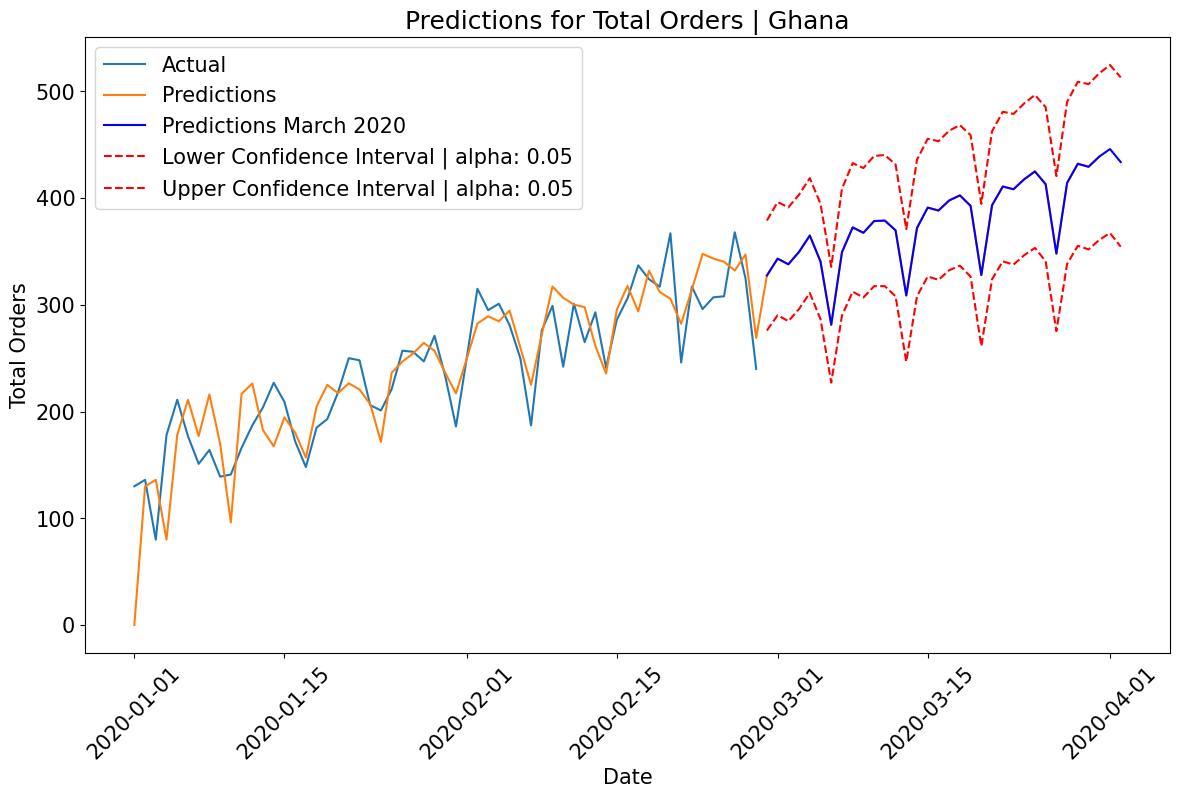

With 95% of confidence, the Total Orders of March 2020 for ghana will vary between: 9733.725306858745 and 13757.239723818268
The expected value for ghana would be: 11745.482515338503


In [15]:
# BEST MODEL SARIMAX(1, 1, 1)x(2, 1, 1, 7) LOWER AIC

SARIMAXmodel = SARIMAX(
    ts, 
    order = (1, 1, 1), 
    seasonal_order=(2, 1, 1, 7),
    dynamic=True)
SARIMAXmodel = SARIMAXmodel.fit()
predictions = SARIMAXmodel.predict(start = '2020-01-01', end = '2020-03-31')


plt.plot(ts, label = 'Actual')
plt.plot(predictions, label = 'Predictions')
plt.ylabel('Total Orders')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title(f"Predictions for Total Orders | {country}")




y_pred_df = pd.DataFrame(
    index=pd.date_range(start='2020-03-01', end ='2020-03-31'),
    columns=['Predictions'],
    data=np.nan)

y_pred = SARIMAXmodel.get_forecast(len(pd.date_range(start='2020-02-27', end ='2020-03-31')))

y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = '2020-01-01', end = '2020-04-30')
# y_pred_df["Predictions"] = SARIMAXmodel.predict(start = '2020-01-01'y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=True)

y_pred_out = y_pred_df["Predictions"]
y_pred_lower = y_pred_df["lower total_orders"]
y_pred_upper = y_pred_df["upper total_orders"]

plt.plot(y_pred_out, color='Blue', label = 'Predictions March 2020')
plt.plot(y_pred_lower, color='Red', label = 'Lower Confidence Interval | alpha: 0.05', linestyle='dashed')
plt.plot(y_pred_upper, color='Red', label = 'Upper Confidence Interval | alpha: 0.05', linestyle='dashed')
plt.legend()
plt.show()

df_final_ghana = y_pred_df[(y_pred_df.index >= '2020-03-01') & (y_pred_df.index <= '2020-03-31')]

print('With 95% of confidence, the Total Orders of March 2020 for ghana will vary between: ' + str(np.sum(df_final_ghana['lower total_orders'])) + ' and ' + str(np.sum(df_final_ghana['upper total_orders'])))
print('The expected value for ghana would be: ' + str(np.sum(df_final_ghana['Predictions'])))    

# Cluster

In [16]:
df_cluster = df_ops_clean.copy()

df_cluster = df_cluster[df_cluster['Order State'] == 'delivered']


df_cluster = df_cluster[[
    'Created Date',
    'Restaurant ID',
    'Country',
    'Order Value € (Gross)'
]]

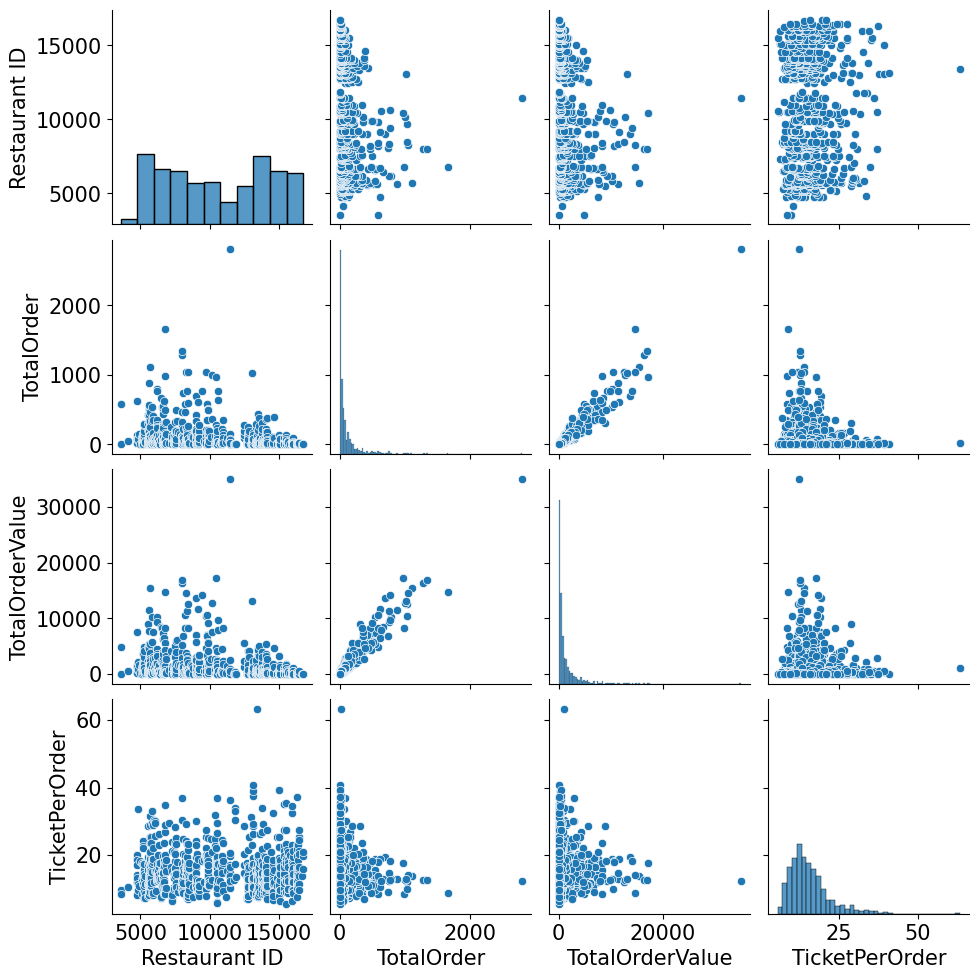

In [17]:
df_cluster_pt = df_cluster.copy()

df_cluster_pt = df_cluster_pt[df_cluster_pt['Country']=='Portugal'].reset_index(drop=True)

df_cluster_pt = df_cluster_pt.groupby(by='Restaurant ID').agg(
    TotalOrder = ('Created Date','count'),
    TotalOrderValue = ('Order Value € (Gross)','sum')
).reset_index()

df_cluster_pt['TicketPerOrder'] = df_cluster_pt['TotalOrderValue'] / df_cluster_pt['TotalOrder']

sns.pairplot(
    data=df_cluster_pt
)

plt.show()

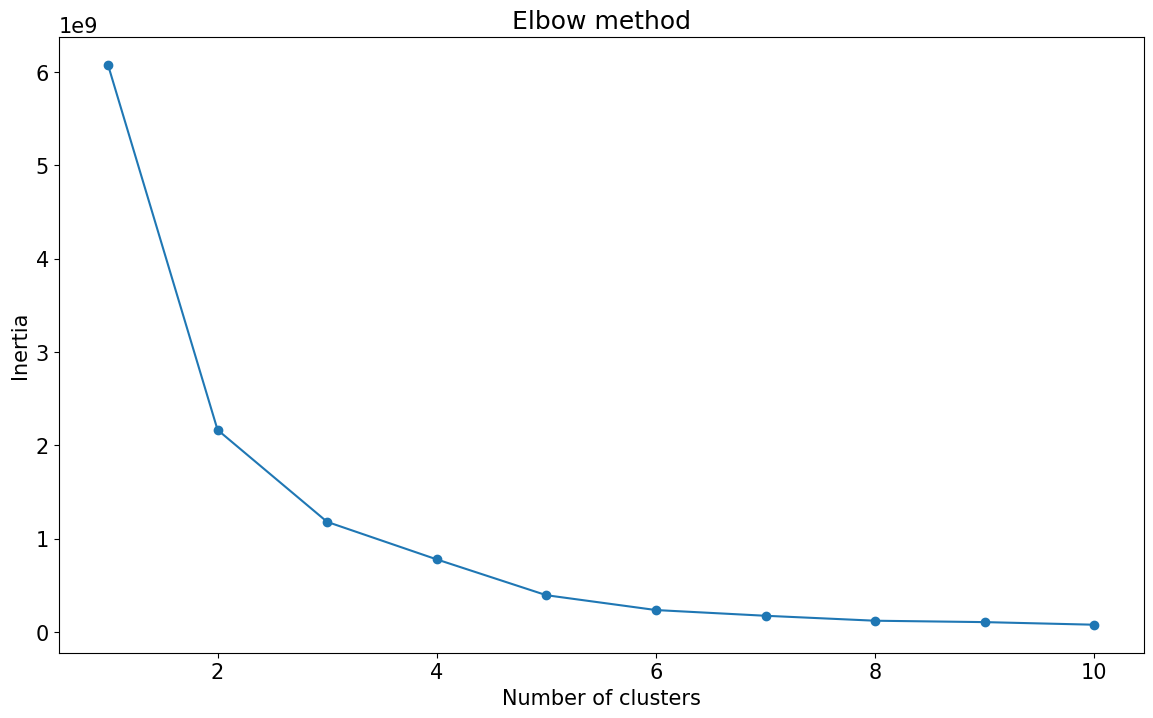

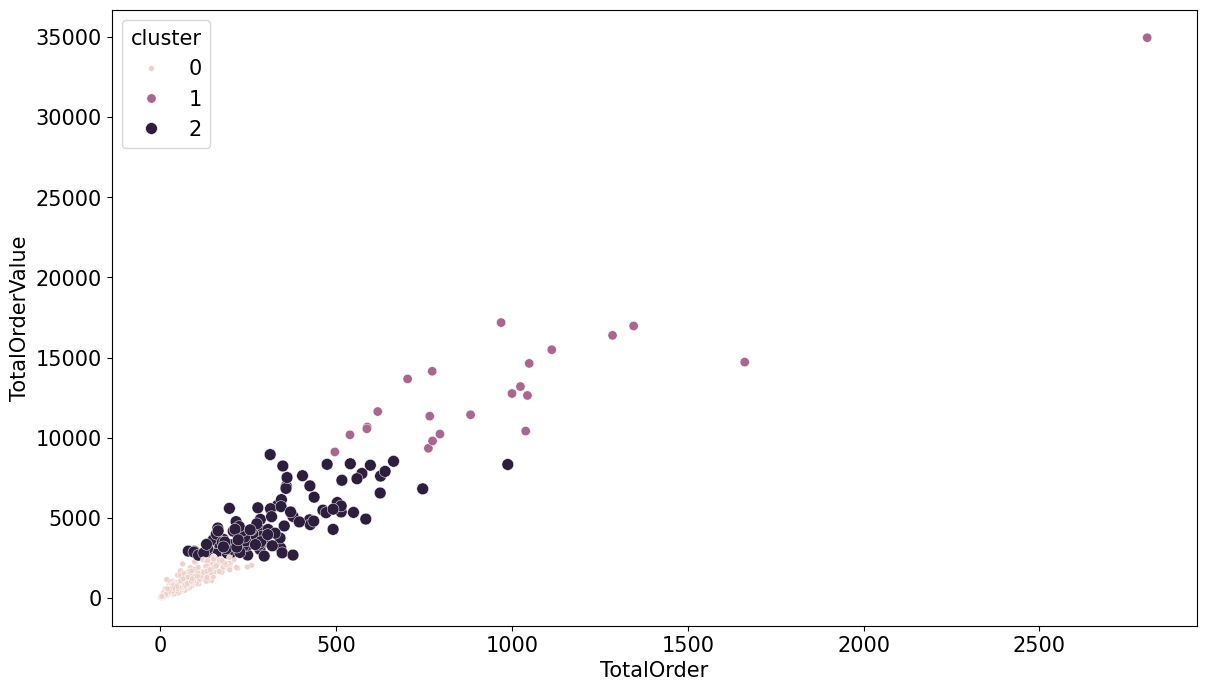

,cluster,total_categories,min_TotalOrder,max_TotalOrder,min_TotalOrderValue,max_TotalOrderValue
1,1,23,496,2807,9106.63000,34961.56000
2,2,107,79,988,2607.73000,8939.89000
0,0,625,1,259,5.75000,2570.19000


In [18]:
data = df_cluster_pt[[
    'TotalOrder',
    'TotalOrderValue'
]]
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(data)

df_cluster_pt['cluster'] = kmeans.labels_


sns.scatterplot(
    df_cluster_pt,
    x='TotalOrder',
    y='TotalOrderValue',
    hue='cluster',
    size='cluster'
)

plt.show()


df_cluster_pt.groupby(by='cluster').agg(
    total_categories = ('cluster','count'),
    min_TotalOrder = ('TotalOrder','min'),
    max_TotalOrder = ('TotalOrder','max'),
    min_TotalOrderValue = ('TotalOrderValue','min'),
    max_TotalOrderValue = ('TotalOrderValue','max')
).reset_index().sort_values(by='max_TotalOrderValue',ascending=False)